In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score as acc_score
from sklearn.tree import DecisionTreeClassifier

# Dataset1 (Adult Dataset)

Preprocessing data
We dropped all missing values and used one-hot encoding to convert discrete values into multiple values.

In [15]:
attributes_list = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
                  'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
                  'result']
cat_attr_list = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex',
                 'native-country', 'result']
train_data_fp = "adult.data"
train_data_list = list()
train_data_list.append(attributes_list)

with open(train_data_fp, encoding='UTF-8') as train_data_file:
    lines = train_data_file.readlines()
    for line in lines:
        line = line.split(', ')
        line[-1] = line[-1][0:-1]
        train_data_list.append(line)
#print(train_data_list[0:10])
train_data_fp = 'adult.csv'
with open(train_data_fp, 'wt', encoding='UTF-8', newline='') as train_data_file:
    csv_writer = csv.writer(train_data_file)
    csv_writer.writerows(train_data_list)

train_data_df = pd.read_csv(train_data_fp)
train_data_df.replace({'?': pd.NA}, inplace=True)
train_data_df.dropna(inplace=True)
train_data_df.reset_index(drop=True, inplace=True)
#print(len(train_data_df))
# Test data preprocessing

test_data_fp = 'adult.test'
test_data_list = list()
test_data_list.append(attributes_list)

with open(test_data_fp, encoding='UTF-8') as test_data_file:
    lines = test_data_file.readlines()
    del lines[0]
    for line in lines:
        line = line.split(', ')
        line[-1] = line[-1][0:-2]
        test_data_list.append(line)

test_data_fp = 'adult_test.csv'
with open(test_data_fp, 'wt', encoding='UTF-8', newline='') as test_data_file:
    csv_writer = csv.writer(test_data_file)
    csv_writer.writerows(test_data_list)

test_data_df = pd.read_csv(test_data_fp)
test_data_df.replace({'?': pd.NA}, inplace=True)
test_data_df.dropna(inplace=True)
test_data_df.reset_index(drop=True, inplace=True)

# One-hot Encoding

merged_df = pd.concat((train_data_df, test_data_df))
merged_df.reset_index(drop=True, inplace=True)
merged_ohe_df = merged_df
for col in cat_attr_list:
    col_ohe = pd.get_dummies(merged_df[col], prefix=col)
    merged_ohe_df = pd.concat((merged_ohe_df, col_ohe), axis=1).drop(col, axis=1)

train_ohe_df = merged_ohe_df.iloc[:30162,:]
train_ohe_df.reset_index(drop=True, inplace=True)
test_ohe_df = merged_ohe_df.iloc[30162:,:]
test_ohe_df.reset_index(drop=True, inplace=True)

train_ohe_df.to_csv(train_data_fp, index=False)
test_ohe_df.to_csv(test_data_fp, index=False)

Implement cross_validate, which separates the training set and validation set. 

In [16]:
def cross_validate(n, k=5):
    #get the number of data samples in each split
    n_val = n // k
    #inds = np.random.permutation(n)
    #inds = []
    for i in range(k):
        tr_inds = list()
        #get the validation indexes
        val_inds = list(range(i * n_val, (i+1)*n_val))
        #get the train indexes
        if i > 0:
            tr_inds = list(range(i*n_val))
        if i < k - 1:
            tr_inds = tr_inds + list(range((i+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

np.random.seed(1)
x = train_ohe_df.drop(columns=['result_<=50K', 'result_>50K']).to_numpy(copy=True)
y = train_ohe_df.iloc[:,-2:].to_numpy(copy=True)
(num_instances, num_features), num_classes = x.shape, np.max(y) + 1
print(num_instances, num_features, num_classes)

30162 104 2


Perform KNN on the data with 5-fold cross validation.

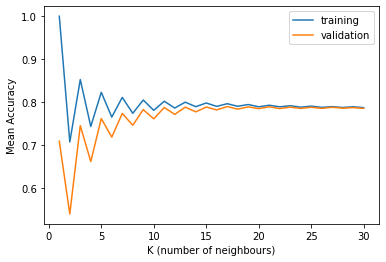

In [9]:
K_list = range(1,31)

num_folds = 5
acc_val, acc_train = np.zeros((len(K_list), num_folds)), np.zeros((len(K_list), num_folds))
for i, K in enumerate(K_list):
    #print(K)
    for j, (tr, val) in enumerate(cross_validate(num_instances)):
        model = KNN(n_neighbors=K)
        model = model.fit(x[tr], y[tr])
        acc_train[i, j] = acc_score(y[tr], model.predict(x[tr]))
        acc_val[i, j] = acc_score(y[val], model.predict(x[val]))
plt.plot(K_list, np.mean(acc_train, axis=1), label='training')
plt.plot(K_list, np.mean(acc_val, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('Mean Accuracy')
plt.show()

Perform KNN on less sample data. 

/var/folders/ym/qmnrgz256jd0p7c2mrxs5jh00000gn/T/ipykernel_27388/3800671752.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


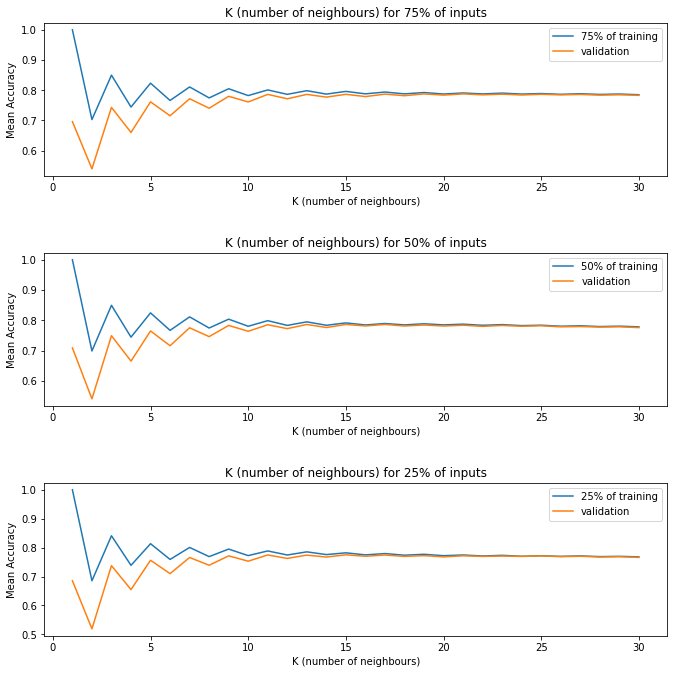

In [11]:
subplot_data = list()
sample_size_list = [0.75, 0.5, 0.25]
for j, prop in enumerate(sample_size_list):
    #print('\n' + str(j) + '\n')
    data_size = int(num_instances * prop)
    inds = np.random.permutation(data_size)
    x_rest, y_rest = x[inds[:]], y[inds[:]]
    n_rest = data_size
    K_list = range(1,31)
    num_folds = 5
    acc_train, acc_valid = np.zeros((len(K_list), num_folds)), np.zeros((len(K_list), num_folds))
    for i, K in enumerate(K_list):
        #print(K)
    # Find the validation errors for num_folds splits for a given K
        for f, (tr, val) in enumerate(cross_validate(data_size)):
            model = KNN(n_neighbors=K)
            model = model.fit(x_rest[tr], y_rest[tr])
            acc_train[i, f] = acc_score(y_rest[tr], model.predict(x_rest[tr]))
            acc_valid[i, f] = acc_score(y_rest[val], model.predict(x_rest[val]))
    subplot_data.append((acc_train, acc_valid))
fig = plt.figure()
for i, prop in enumerate(sample_size_list, start=1):
    ax = fig.add_subplot(3, 1, i)
    (acc_train, acc_valid) = subplot_data[i - 1]
    ax.plot(K_list, np.mean(acc_train, axis=1), label=(str(int(prop*100)) + '% of training'))
    ax.plot(K_list, np.mean(acc_valid, axis=1), label='validation')
    ax.set_title('K (number of neighbours) for ' + str(int(prop * 100)) + '% of inputs')
    ax.set(xlabel='K (number of neighbours)', ylabel='Mean Accuracy')
    ax.legend()
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout(pad=3.0)
fig.show()

Perform decision tree

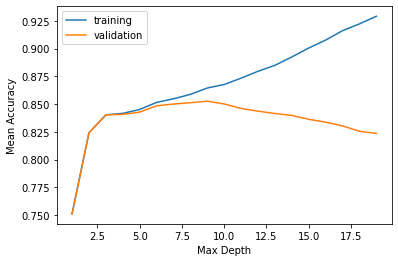

In [51]:
max_depth = range(1,20)
num_folds = 5
acc_train, acc_valid = np.zeros((len(max_depth), num_folds)), np.zeros((len(max_depth), num_folds))
for i, depth in enumerate(max_depth):
    for f, (tr, val) in enumerate(cross_validate(num_instances)):
        model = DecisionTreeClassifier(max_depth=depth)
        model = model.fit(x[tr], y[tr])
        acc_train[i, f] = acc_score(y[tr], model.predict(x[tr]))
        acc_valid[i, f] = acc_score(y[val], model.predict(x[val]))

plt.plot(max_depth, np.mean(acc_train, axis=1), label='training')
plt.plot(max_depth, np.mean(acc_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Mean Accuracy')
plt.show()

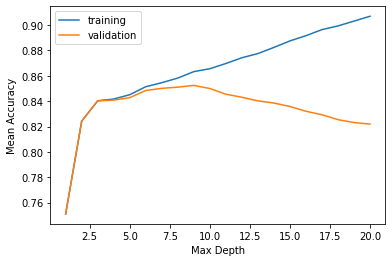

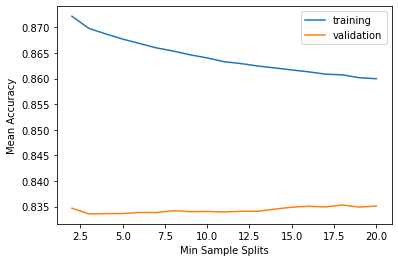

In [5]:
max_depth = range(1, 21)
min_sample_splits = range(2, 21)
num_folds = 5
acc_train, acc_valid = np.zeros((len(max_depth), len(min_sample_splits), num_folds)), np.zeros((len(max_depth), len(min_sample_splits), num_folds))
for i, depth in enumerate(max_depth):
    for j, split in enumerate(min_sample_splits):
        for f, (tr, val) in enumerate(cross_validate(num_instances)):
            model = DecisionTreeClassifier(max_depth=depth, min_samples_split=split)
            model = model.fit(x[tr], y[tr])
            acc_train[i, j, f] = acc_score(y[tr], model.predict(x[tr]))
            acc_valid[i, j, f] = acc_score(y[val], model.predict(x[val]))
#print(acc_train)
#print(acc_valid)

def get_split_mean(result, para = split):
    split_mean_set = []
    for i in range(len(result[0])):
        mean_for_i = np.mean(result[:,i,:])
        split_mean_set.append(mean_for_i)
    return split_mean_set

def get_depth_mean(result, para = depth):
    depth_mean_set = []
    for i in range(len(result)):
        mean_for_i = np.mean(result[i,::])
        depth_mean_set.append(mean_for_i)
    return depth_mean_set

plt.plot(max_depth, get_depth_mean(acc_train,depth), label='training')
plt.plot(max_depth, get_depth_mean(acc_valid,depth), label='validation')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Mean Accuracy')
plt.show()


plt.plot(min_sample_splits, get_split_mean(acc_train, split), label='training')
plt.plot(min_sample_splits, get_split_mean(acc_valid, split), label='validation')
plt.legend()
plt.xlabel('Min Sample Splits')
plt.ylabel('Mean Accuracy')
plt.show()

Perform decision tree on less sample data

/var/folders/ym/qmnrgz256jd0p7c2mrxs5jh00000gn/T/ipykernel_27388/296160474.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


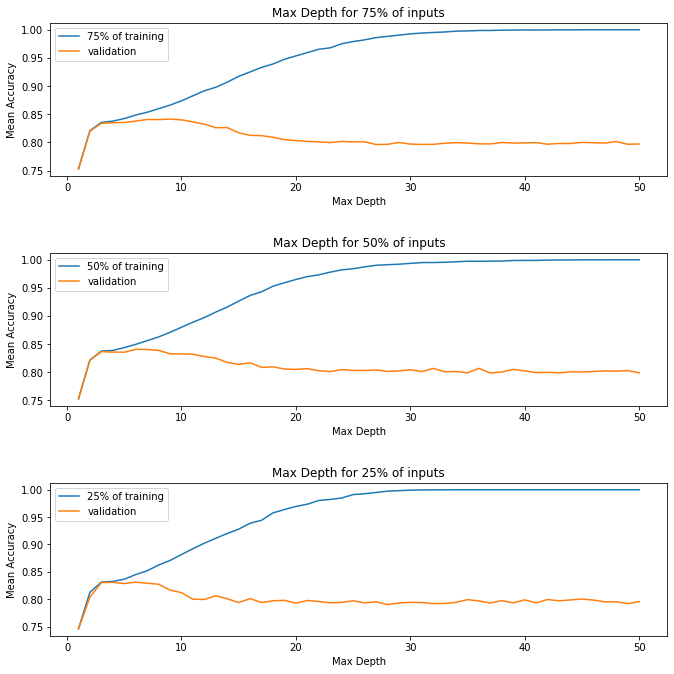

In [42]:
subplot_data = list()
sample_size_list = [0.75, 0.5, 0.25]
for j, prop in enumerate(sample_size_list):
    #print('\n' + str(j) + '\n')
    data_size = int(num_instances * prop)
    inds = np.random.permutation(data_size)
    x_rest, y_rest = x[inds[:]], y[inds[:]]
    n_rest = data_size
    max_depth = range(1,51)
    num_folds = 5
    acc_train, acc_valid = np.zeros((len(max_depth), num_folds)), np.zeros((len(max_depth), num_folds))
    for i, depth in enumerate(max_depth):
        #print(depth)
    # Find the validation errors for num_folds splits for a given K
        for f, (tr, val) in enumerate(cross_validate(data_size)):
            model = DecisionTreeClassifier(max_depth=depth)
            model = model.fit(x_rest[tr], y_rest[tr])
            acc_train[i, f] = acc_score(y_rest[tr], model.predict(x_rest[tr]))
            acc_valid[i, f] = acc_score(y_rest[val], model.predict(x_rest[val]))
    subplot_data.append((acc_train, acc_valid))
fig = plt.figure()
for i, prop in enumerate(sample_size_list, start=1):
    ax = fig.add_subplot(3, 1, i)
    (acc_train, acc_valid) = subplot_data[i - 1]
    ax.plot(max_depth, np.mean(acc_train, axis=1), label=(str(int(prop*100)) + '% of training'))
    ax.plot(max_depth, np.mean(acc_valid, axis=1), label='validation')
    ax.set_title('Max Depth for ' + str(int(prop * 100)) + '% of inputs')
    ax.set(xlabel='Max Depth', ylabel='Mean Accuracy')
    ax.legend()
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout(pad=3.0)
fig.show()

Test the models we select on the test set

In [8]:
x_test = test_ohe_df.drop(columns=['result_<=50K', 'result_>50K']).to_numpy(copy=True)
y_test = test_ohe_df.iloc[:,-2:].to_numpy(copy=True)
(num_instances, num_features), num_classes = x_test.shape, np.max(y_test) + 1
model = KNN(n_neighbors=9)
model = model.fit(x, y)
print('Accuracy for K = 9: '  + str(acc_score(y_test, model.predict(x_test))))

model = DecisionTreeClassifier(max_depth=9, min_samples_split=2)
model = model.fit(x, y)
print('Accuracy for Max Depth = 9, Min Samples Split = 2: ' + str(acc_score(y_test, model.predict(x_test))))

Accuracy for K = 9: 0.7830013280212483
Accuracy for Max Depth = 9, Min Samples Split = 2: 0.8531208499335989


Generate a correlation matrix, from which we could see that marital status and relationship are the two features most important, since they have the highest correlation value with the target.

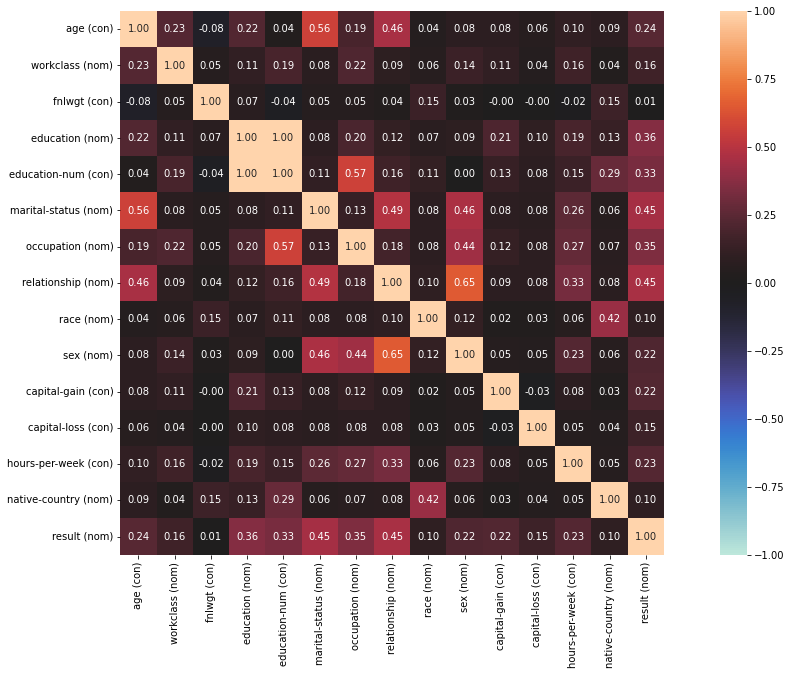

{'corr':                       age (con)  workclass (nom)  fnlwgt (con)  \
 age (con)              1.000000         0.228118     -0.075792   
 workclass (nom)        0.228118         1.000000      0.053785   
 fnlwgt (con)          -0.075792         0.053785      1.000000   
 education (nom)        0.221375         0.108200      0.068242   
 education-num (con)    0.037623         0.188008     -0.041993   
 marital-status (nom)   0.564323         0.076566      0.053437   
 occupation (nom)       0.190133         0.216289      0.049354   
 relationship (nom)     0.459297         0.087911      0.037692   
 race (nom)             0.039314         0.058520      0.146655   
 sex (nom)              0.082053         0.143487      0.027240   
 capital-gain (con)     0.079683         0.108063     -0.004110   
 capital-loss (con)     0.059351         0.044885     -0.004349   
 hours-per-week (con)   0.101992         0.159330     -0.018679   
 native-country (nom)   0.085234         0.038668     

In [44]:
from dython import nominal
nominal.associations(merged_df,figsize=(20,10),mark_columns=True)

We could treat the missing values in the dataset in another way, instead of simply removing the rows. For categorical missing values, we replace them with values that appear the most in the column. For numerical missing values, we replace them with the mean of other values in the column.

In [17]:
# constant variables

attributes_list = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
                  'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
                  'result']
cat_attr_list = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex',
                 'native-country', 'result']

# Train data preprocessing

train_data_fp = 'adult.data'
train_data_list = list()
train_data_list.append(attributes_list)

with open(train_data_fp, encoding='UTF-8') as train_data_file:
    lines = train_data_file.readlines()
    for line in lines:
        line = line.split(', ')
        line[-1] = line[-1][0:-1]
        train_data_list.append(line)
train_data_fp = 'adult.csv'
with open(train_data_fp, 'wt', encoding='UTF-8', newline='') as train_data_file:
    csv_writer = csv.writer(train_data_file)
    csv_writer.writerows(train_data_list)

train_data_df = pd.read_csv(train_data_fp)
train_data_df.replace({'?': pd.NA}, inplace=True)
for col in train_data_df.columns:
    if col in cat_attr_list:
        train_data_df[col].fillna(train_data_df[col].mode()[0], inplace=True)
    else:
        train_data_df[col].fillna(train_data_df[col].mean(), inplace=True)
#train_data_df.dropna(inplace=True)
train_data_df.reset_index(drop=True, inplace=True)
#print(train_data_df)

# Test data preprocessing

test_data_fp = 'adult.test'
test_data_list = list()
test_data_list.append(attributes_list)

with open(test_data_fp, encoding='UTF-8') as test_data_file:
    lines = test_data_file.readlines()
    del lines[0]
    for line in lines:
        line = line.split(', ')
        line[-1] = line[-1][0:-2]
        test_data_list.append(line)

test_data_fp = 'adult_test.csv'
with open(test_data_fp, 'wt', encoding='UTF-8', newline='') as test_data_file:
    csv_writer = csv.writer(test_data_file)
    csv_writer.writerows(test_data_list)

test_data_df = pd.read_csv(test_data_fp)
test_data_df.replace({'?': pd.NA}, inplace=True)
for col in test_data_df.columns:
    if col in cat_attr_list:
        test_data_df[col].fillna(test_data_df[col].mode()[0], inplace=True)
    else:
        test_data_df[col].fillna(test_data_df[col].mean(), inplace=True)
#test_data_df.dropna(inplace=True)
test_data_df.reset_index(drop=True, inplace=True)
#print(test_data_df)

# One-hot Encoding

merged_df = pd.concat((train_data_df, test_data_df))
merged_df.reset_index(drop=True, inplace=True)
merged_ohe_df = merged_df
for col in cat_attr_list:
    col_ohe = pd.get_dummies(merged_df[col], prefix=col)
    merged_ohe_df = pd.concat((merged_ohe_df, col_ohe), axis=1).drop(col, axis=1)

train_ohe_df = merged_ohe_df.iloc[:30162,:]
train_ohe_df.reset_index(drop=True, inplace=True)
test_ohe_df = merged_ohe_df.iloc[30162:,:]
test_ohe_df.reset_index(drop=True, inplace=True)

train_ohe_df.to_csv(train_data_fp, index=False)
test_ohe_df.to_csv(test_data_fp, index=False)

Generate accuracy plot on the new dataset.

In [18]:
np.random.seed(1)
x = train_ohe_df.drop(columns=['result_<=50K', 'result_>50K']).to_numpy(copy=True)
y = train_ohe_df.iloc[:,-2:].to_numpy(copy=True)
(num_instances, num_features), num_classes = x.shape, np.max(y) + 1
#print(num_instances, num_features, num_classes)

Apply new dataset to perform KNN

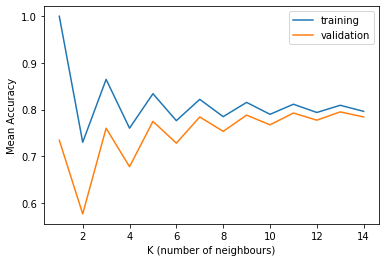

In [19]:
K_list = range(1,15)

num_folds = 5
acc_val, acc_train = np.zeros((len(K_list), num_folds)), np.zeros((len(K_list), num_folds))
for i, K in enumerate(K_list):
    #print(K)
    for j, (tr, val) in enumerate(cross_validate(num_instances)):
        model = KNN(n_neighbors=K)
        model = model.fit(x[tr], y[tr])
        acc_train[i, j] = acc_score(y[tr], model.predict(x[tr]))
        acc_val[i, j] = acc_score(y[val], model.predict(x[val]))
plt.plot(K_list, np.mean(acc_train, axis=1), label='training')
plt.plot(K_list, np.mean(acc_val, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('Mean Accuracy')
plt.show()

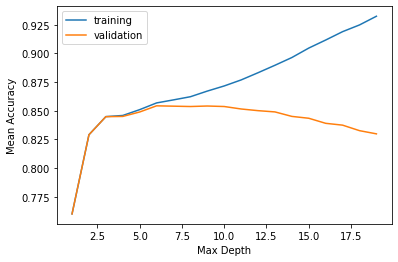

In [20]:
max_depth = range(1,20)
num_folds = 5
acc_train, acc_valid = np.zeros((len(max_depth), num_folds)), np.zeros((len(max_depth), num_folds))
for i, depth in enumerate(max_depth):
    for f, (tr, val) in enumerate(cross_validate(num_instances)):
        model = DecisionTreeClassifier(max_depth=depth)
        model = model.fit(x[tr], y[tr])
        acc_train[i, f] = acc_score(y[tr], model.predict(x[tr]))
        acc_valid[i, f] = acc_score(y[val], model.predict(x[val]))

plt.plot(max_depth, np.mean(acc_train, axis=1), label='training')
plt.plot(max_depth, np.mean(acc_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Mean Accuracy')
plt.show()

# Dataset2 (Letter Recognition dataset)

In [9]:
attributes_list = ['lettr', 'x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar',
                   'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx']
cat_attr_list = ['lettr']

df = pd.read_csv("letter-recognition.data",encoding='UTF-8',names=attributes_list)

Processing the dataset. Since there are no missing values, we simply use one-hot encoding to accomodate the categorical value. 

In [10]:
ohe_df = df
for col in cat_attr_list:
    col_ohe = pd.get_dummies(df[col], prefix=col)
    ohe_df = pd.concat((ohe_df, col_ohe), axis=1).drop(col, axis=1)

train_ohe_df = ohe_df.iloc[:16000, :]
train_ohe_df.reset_index(drop=True, inplace=True)
test_ohe_df = ohe_df.iloc[16000:, :]
test_ohe_df.reset_index(drop=True, inplace=True)

In [11]:
def cross_validate(n, k=5):
    #get the number of data samples in each split
    n_val = n // k
    for i in range(k):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(i * n_val, (i+1)*n_val))
        #get the train indexes
        if i > 0:
            tr_inds = list(range(i*n_val))
        if i < k - 1:
            tr_inds = tr_inds + list(range((i+1)*n_val, n))
        yield tr_inds, val_inds

np.random.seed(1)

x = train_ohe_df.iloc[:,:-26].to_numpy(copy=True)
y = train_ohe_df.iloc[:,-26:].to_numpy(copy=True)
(num_instances, num_features), num_classes = x.shape, len(y[0])
print(num_instances, num_features, num_classes)


n_test = 4000
inds = np.random.permutation(num_instances)
x_rest, y_rest = x[inds[:]], y[inds[:]]
n_rest = num_instances


16000 16 26


Perform KNN on the training/validation set

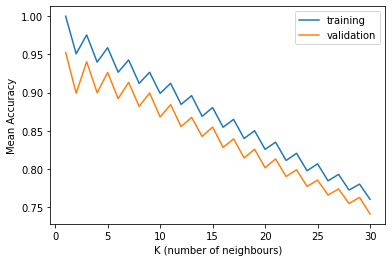

In [5]:
K_list = range(1,31)
num_folds = 5
acc_train, acc_valid = np.zeros((len(K_list), num_folds)), np.zeros((len(K_list), num_folds))
for i, K in enumerate(K_list):
    # Find the validation errors for num_folds splits for a given K
    #print(K)
    for f, (tr, val) in enumerate(cross_validate(num_instances)):
        model = KNN(n_neighbors=K)
        model = model.fit(x_rest[tr], y_rest[tr])
        acc_train[i, f] = acc_score(y_rest[tr], model.predict(x_rest[tr]))
        acc_valid[i, f] = acc_score(y_rest[val], model.predict(x_rest[val]))

plt.plot(K_list, np.mean(acc_train, axis=1), label='training')
plt.plot(K_list, np.mean(acc_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('Mean Accuracy')
plt.show()

Perform decision tree on training/validation data, and treat max_depth as the only one hyper-parameter

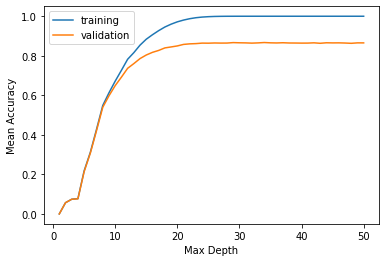

In [21]:
max_depth = range(1,51)
num_folds = 5
acc_train,acc_valid = np.zeros((len(max_depth),num_folds)),np.zeros((len(max_depth),num_folds))
for i, depth in enumerate(max_depth):
    for f, (tr,val) in enumerate(cross_validate(num_instances)):
        model = DecisionTreeClassifier(max_depth = depth)
        model = model.fit(x_rest[tr], y_rest[tr])
        acc_train[i,f] = acc_score(y_rest[tr],model.predict(x_rest[tr]))
        acc_valid[i,f] = acc_score(y_rest[val],model.predict(x_rest[val]))
        
plt.plot(max_depth, np.mean(acc_train, axis=1), label='training')
plt.plot(max_depth, np.mean(acc_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Mean Accuracy')
plt.show()

Perform decision tree, while implementing 5-fold cross validation manully for hyper-parameters including max_depth and min_sample_splits

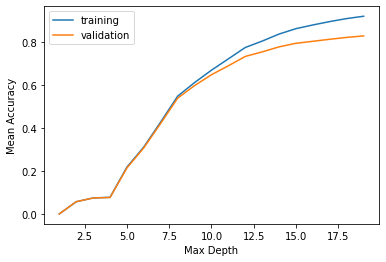

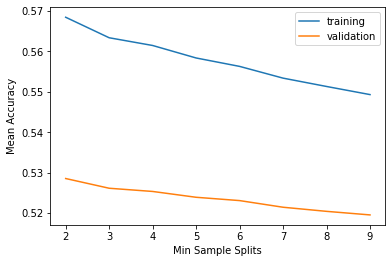

In [75]:
max_depth = range(1,20)
min_sample_splits = range(2,10)
num_folds = 5
acc_train, acc_valid = np.zeros((len(max_depth), len(min_sample_splits), num_folds)), np.zeros((len(max_depth), len(min_sample_splits), num_folds))
for i, depth in enumerate(max_depth):
    for j, split in enumerate(min_sample_splits):
        for f, (tr, val) in enumerate(cross_validate(num_instances)):
            model = DecisionTreeClassifier(max_depth=depth, min_samples_split = split)
            model = model.fit(x_rest[tr], y_rest[tr])
            acc_train[i, j, f] = acc_score(y_rest[tr], model.predict(x_rest[tr]))
            acc_valid[i, j, f] = acc_score(y_rest[val], model.predict(x_rest[val]))
#print(acc_train)
#print(acc_valid)

def get_split_mean(result, para = split):
    split_mean_set = []
    for i in range(len(result[0])):
        mean_for_i = np.mean(result[:,i,:])
        split_mean_set.append(mean_for_i)
    return split_mean_set

def get_depth_mean(result, para = depth):
    depth_mean_set = []
    for i in range(len(result)):
        mean_for_i = np.mean(result[i,::])
        depth_mean_set.append(mean_for_i)
    return depth_mean_set

plt.plot(max_depth, get_depth_mean(acc_train,depth), label='training')
plt.plot(max_depth, get_depth_mean(acc_valid,depth), label='validation')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Mean Accuracy')
plt.show()


plt.plot(min_sample_splits, get_split_mean(acc_train, split), label='training')
plt.plot(min_sample_splits, get_split_mean(acc_valid, split), label='validation')
plt.legend()
plt.xlabel('Min Sample Splits')
plt.ylabel('Mean Accuracy')
plt.show()

Perform KNN on less sample data

/var/folders/ym/qmnrgz256jd0p7c2mrxs5jh00000gn/T/ipykernel_26822/1040989272.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


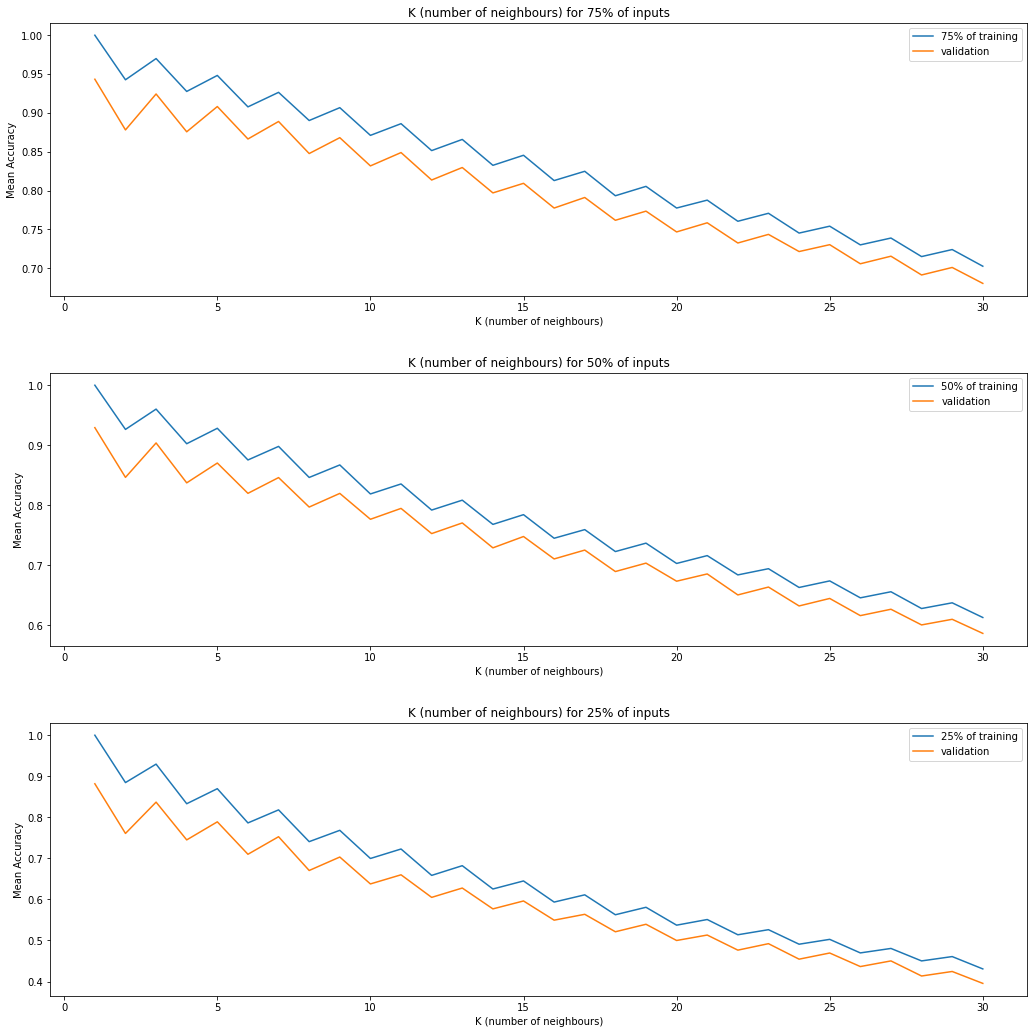

In [6]:
subplot_data = list()
sample_size_list = [0.75, 0.5, 0.25]
for j, prop in enumerate(sample_size_list):
    #print('\n' + str(j) + '\n')
    data_size = int(num_instances * prop)
    inds = np.random.permutation(data_size)
    x_rest, y_rest = x[inds[:]], y[inds[:]]
    n_rest = data_size
    K_list = range(1,31)
    num_folds = 5
    acc_train, acc_valid = np.zeros((len(K_list), num_folds)), np.zeros((len(K_list), num_folds))
    for i, K in enumerate(K_list):
        #print(K)
    # Find the validation errors for num_folds splits for a given K
        for f, (tr, val) in enumerate(cross_validate(data_size)):
            model = KNN(n_neighbors=K)
            model = model.fit(x_rest[tr], y_rest[tr])
            acc_train[i, f] = acc_score(y_rest[tr], model.predict(x_rest[tr]))
            acc_valid[i, f] = acc_score(y_rest[val], model.predict(x_rest[val]))
    subplot_data.append((acc_train, acc_valid))
fig = plt.figure()
for i, prop in enumerate(sample_size_list, start=1):
    ax = fig.add_subplot(3, 1, i)
    (acc_train, acc_valid) = subplot_data[i - 1]
    ax.plot(K_list, np.mean(acc_train, axis=1), label=(str(int(prop*100)) + '% of training'))
    ax.plot(K_list, np.mean(acc_valid, axis=1), label='validation')
    ax.set_title('K (number of neighbours) for ' + str(int(prop * 100)) + '% of inputs')
    ax.set(xlabel='K (number of neighbours)', ylabel='Mean Accuracy')
    ax.legend()
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout(pad=3.0)
fig.show()

In [ ]:
Perfrom decision trees on less sample data, to see the effect of the size of the sample data.

/var/folders/ym/qmnrgz256jd0p7c2mrxs5jh00000gn/T/ipykernel_26822/1024598476.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


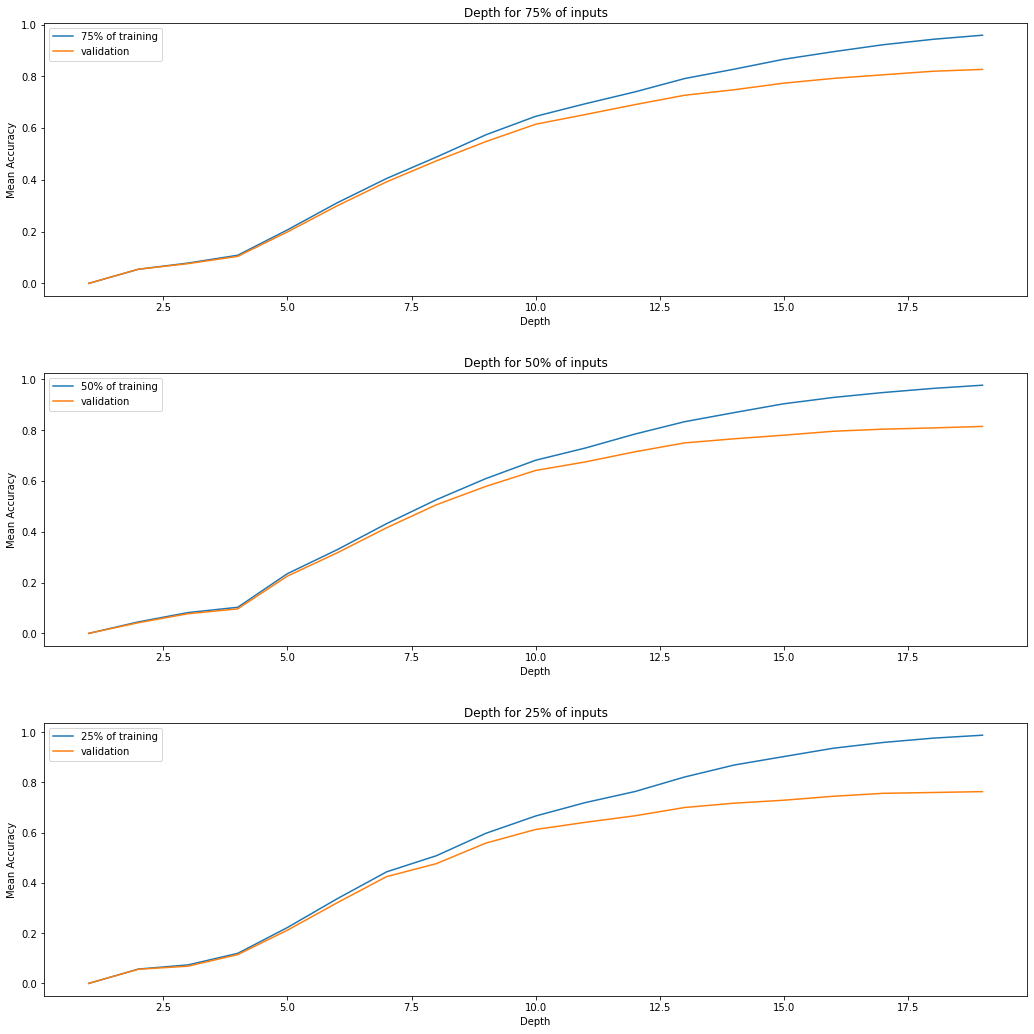

In [7]:
subplot_data = list()
sample_size_list = [0.75, 0.5, 0.25]
for j, prop in enumerate(sample_size_list):
    #print('\n' + str(j) + '\n')
    data_size = int(num_instances * prop)
    inds = np.random.permutation(data_size)
    x_rest, y_rest = x[inds[:]], y[inds[:]]
    n_rest = data_size
    max_depth = range(1,20)
    num_folds = 5
    acc_train, acc_valid = np.zeros((len(max_depth), num_folds)), np.zeros((len(max_depth), num_folds))
    for i, depth in enumerate(max_depth):
        #print(K)
    # Find the validation errors for num_folds splits for a given K
        for f, (tr, val) in enumerate(cross_validate(data_size)):
            model = DecisionTreeClassifier(max_depth = depth)
            model = model.fit(x_rest[tr], y_rest[tr])
            acc_train[i, f] = acc_score(y_rest[tr], model.predict(x_rest[tr]))
            acc_valid[i, f] = acc_score(y_rest[val], model.predict(x_rest[val]))
    subplot_data.append((acc_train, acc_valid))
fig = plt.figure()
for i, prop in enumerate(sample_size_list, start=1):
    ax = fig.add_subplot(3, 1, i)
    (acc_train, acc_valid) = subplot_data[i - 1]
    ax.plot(max_depth, np.mean(acc_train, axis=1), label=(str(int(prop*100)) + '% of training'))
    ax.plot(max_depth, np.mean(acc_valid, axis=1), label='validation')
    ax.set_title('Depth for ' + str(int(prop * 100)) + '% of inputs')
    ax.set(xlabel='Depth', ylabel='Mean Accuracy')
    ax.legend()
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout(pad=3.0)
fig.show()

In [12]:
x_test = test_ohe_df.iloc[:,:-26].to_numpy(copy=True)
y_test = test_ohe_df.iloc[:,-26:].to_numpy(copy=True)

Apply both models on the test data.

In [13]:
#Apply knn with k = 3
knn = KNN(n_neighbors = 3)
knn.fit(x_rest,y_rest) 
knn.score(x_test,y_test)

0.94525

In [14]:
#Apply dt with depth = 20, 
dt = DecisionTreeClassifier(max_depth=20,min_samples_split=2)
dt.fit(x_rest,y_rest)
dt.score(x_test,y_test) 

0.86025

Generate a correlation matrix, from which we could see that x2ybr and y-bar are the two most useful features among all the features, since they have the highest correlation values corresponding to the target. 

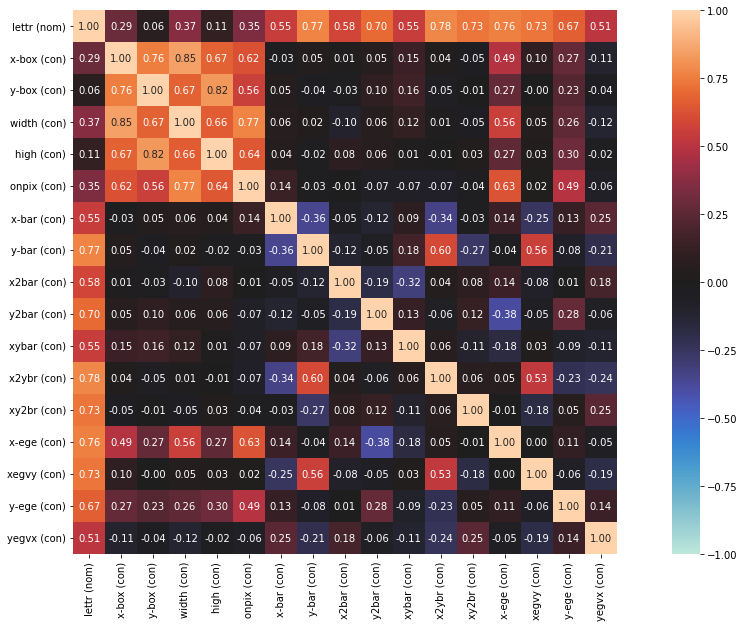

{'corr':              lettr (nom)  x-box (con)  y-box (con)  width (con)  high (con)  \
 lettr (nom)     1.000000     0.294755     0.064504     0.373609    0.113017   
 x-box (con)     0.294755     1.000000     0.757793     0.851514    0.672764   
 y-box (con)     0.064504     0.757793     1.000000     0.671912    0.823207   
 width (con)     0.373609     0.851514     0.671912     1.000000    0.660215   
 high (con)      0.113017     0.672764     0.823207     0.660215    1.000000   
 onpix (con)     0.349062     0.619097     0.555067     0.765716    0.644366   
 x-bar (con)     0.551428    -0.032595     0.045690     0.061959    0.042844   
 y-bar (con)     0.771150     0.045545    -0.040925     0.024832   -0.020072   
 x2bar (con)     0.581039     0.014306    -0.025019    -0.098611    0.082383   
 y2bar (con)     0.696425     0.052086     0.096478     0.057074    0.059032   
 xybar (con)     0.551640     0.148056     0.159954     0.115018    0.012458   
 x2ybr (con)     0.780008     0.

In [19]:
from dython import nominal
nominal.associations(df,figsize=(20,10),mark_columns=True)

We can see from the outputs that the choice of hyper-parameters affects the classification accuracy on test data. By 5-fold cross-validation, we could find an appropriate hyper-parameter that suits the data. For a specific type of model, as the size of the training data increases, the accuracy achieved would increase as well. 